# Testing Tabular SR

In [3]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import partial
from IPython.display import clear_output

%matplotlib inline

In [5]:
def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

In [ ]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset(seed=13)
plt.imshow(env.render())

## Q-learning

In [35]:
class DecayVal:
    val: float
    decay: float
    schedule: int
    def __init__(self, val, decay, schedule):
        self.val = val
        self.decay = decay
        self.i = 0
        self.schedule = schedule

    def __call__(self):
        return self.val

    def step(self):
        self.i += 1
        if self.i % self.schedule == 0:
            self.val *= self.decay


class QAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)

    def reset(self):
        self.eps.step()
        self.lr.step()
        
    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps():
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, done):
        # реализуйте шаг Q-обучения
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        Q_s_a = self.Q[s, a]
        V_sn = np.max(self.Q[s_n])

        td_error = r + self.gamma * (1-done) * V_sn - Q_s_a
        self.Q[s, a] += self.lr() * td_error

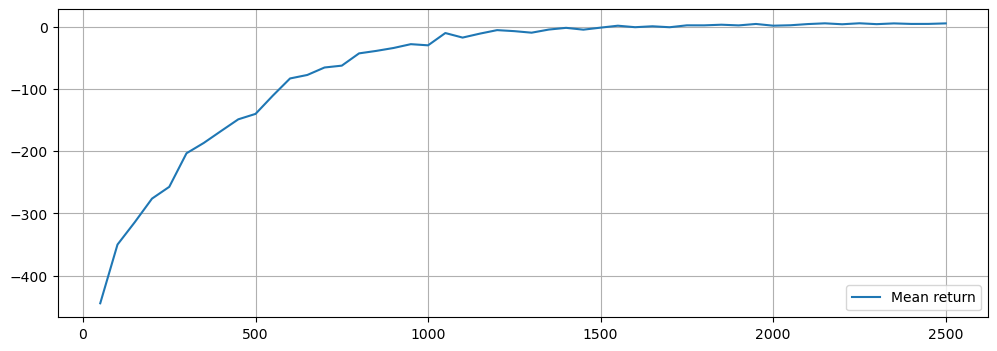

Episode: 2500, Return: -2, AvgReturn[50]: 5


(0.04669747052543716, 0.03221225472000002)

In [74]:
def train(env, agent, n_episodes, seed, show_progress_schedule=50):
    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes+1):
        state, _ = env.reset(seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)

            # выполняем действие в среде
            next_state, reward, terminated, truncated, info = env.step(action)
            # шаг обучения
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            episode_return += reward
            done = terminated or truncated
            if done:
                agent.reset()
                break

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []
            
            show_progress(avg_returns)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )

    return avg_returns

env = gym.make("Taxi-v3")
seed = 1337
agent = QAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
)

log_q = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

## SR

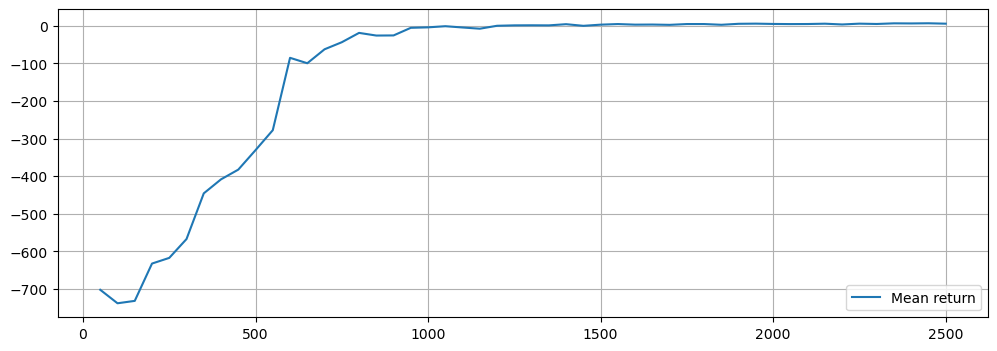

Episode: 2500, Return: 8, AvgReturn[50]: 5


(0.04669747052543716, 0.03221225472000002)

In [70]:
class SrAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, seed, sarsa=False):
        self.r = np.zeros((n_states,))
        self.M = np.zeros((n_states, n_actions, n_states))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self.sarsa = sarsa
        self._rng = np.random.default_rng(seed)

    def reset(self):
        self.eps.step()
        self.lr.step()

    def Q(self, s):
        return np.dot(self.M[s], self.r)
        
    def act(self, s, greedy=False):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if not greedy and self._rng.random() < self.eps():
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q(s))  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, done):
        # реализуйте шаг Q-обучения
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        self.r[s_n] += self.lr() * (r - self.r[s_n])

        # do I need max(M)?
        a_n = self.act(s_n, greedy=not self.sarsa)

        target = self.gamma * (1 - done) * self.M[s_n, a_n]
        target[s_n] += 1.
        
        td_error = target - self.M[s,a]
        self.M[s, a] += self.lr() * td_error

env = gym.make("Taxi-v3")
seed = 1337
agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
    sarsa=False
)

log_q_sr = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

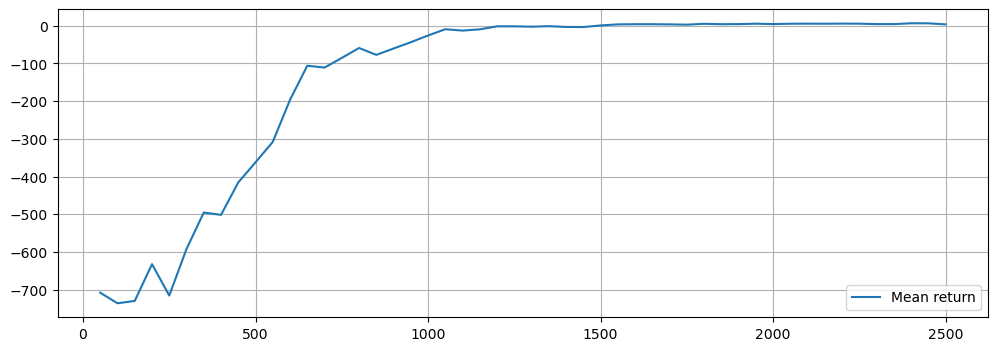

Episode: 2500, Return: 8, AvgReturn[50]: 4


(0.04669747052543716, 0.03221225472000002)

In [72]:
env = gym.make("Taxi-v3")
seed = 1337
agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
    sarsa=True
)

log_sarsa_sr = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

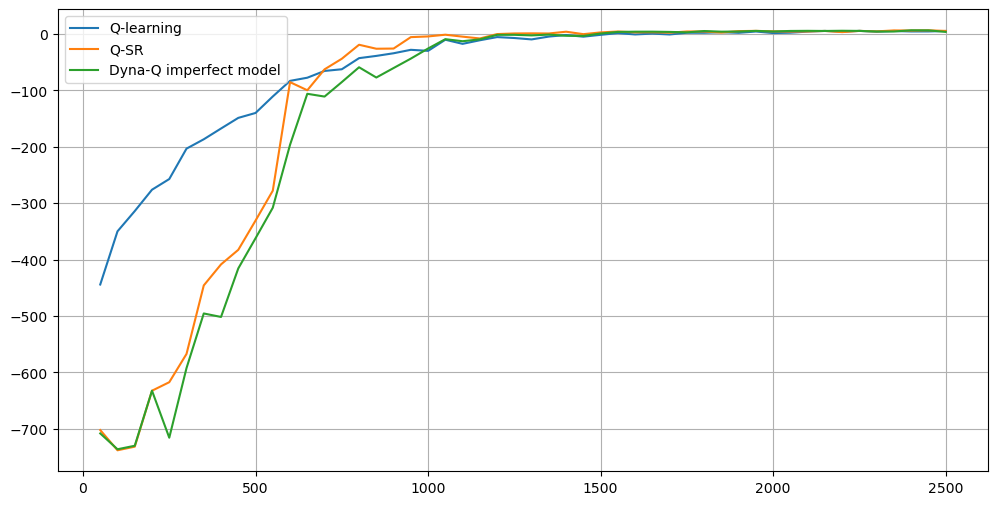

In [75]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_q_sr, 'Q-SR'),
    (log_sarsa_sr, 'Dyna-Q imperfect model'),
])

In [57]:
from IPython.display import Video
from IPython import display

def show_video(path):
    display(Video(path, embed=True))